In [1]:
import random

import linear_unpredictability as linupred
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import real_data_loader
import torch

## Set seeds for reconstruction of the results

In [2]:
# Set seeds.
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

#### Load Data

Filter out selected times and stocks

In [3]:
real_loader = real_data_loader.RealDataLoader(cache="../data/cache")
real_data = real_loader.get_timeseries(
    col_name="Adj Close", data_path="../data/raw_yahoo_data", update_all=False
)

Cached data found at ../data/cache/time_series_Adj_Close.csv.


Inspect data for missing information

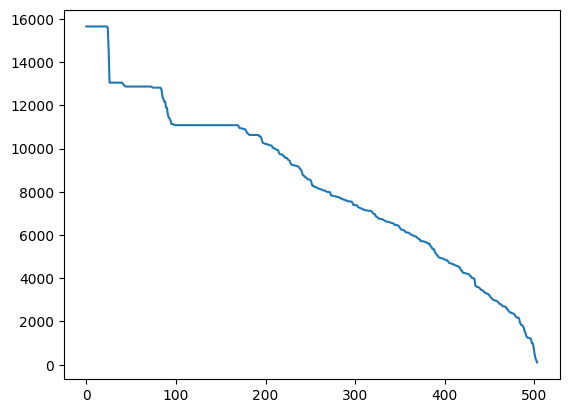

In [4]:
N_STOCKS = 9216
nan_mask = ~np.isnan(real_data)  # returns pd.dataframe
num_non_nans: pd.DataFrame = np.sum(nan_mask, axis=0)
non_nan_orderd_stocks: pd.DataFrame = num_non_nans.sort_values(ascending=False)
plt.plot(non_nan_orderd_stocks.values)
stocks = non_nan_orderd_stocks.iloc[non_nan_orderd_stocks.values >= N_STOCKS].index

In [5]:
# stocks = ["MSFT", "AAPL", "IBM", "ADBE", "ORCL", "INTC", "AMD", "HPQ"]
# stocks = ['MSFT']
first_date = real_data.index[-N_STOCKS]
real_data = real_data.loc[first_date:, stocks]
assert np.all(~np.isnan(real_data))
print(f"Shape: {real_data.shape}")

Shape: (9216, 233)


In [6]:
np_data = np.array(real_data)
np_ret = np.log(np_data[1:] / np_data[:-1])
np_ret[np.abs(np_ret) >= 2] = 0  # clean data

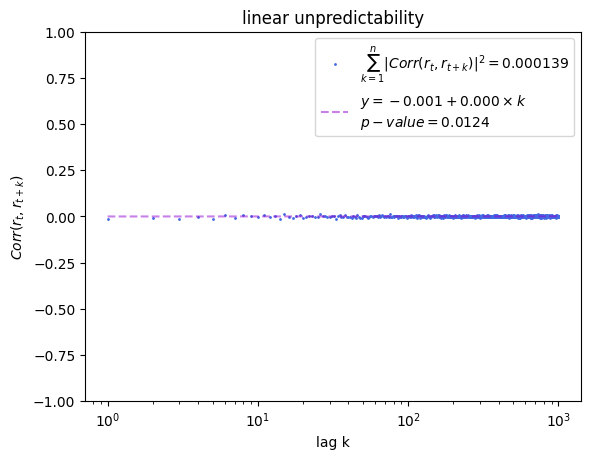

In [7]:
data = linupred.linear_unpredictability_stats(log_returns=np_ret, max_lag=1000)
ac_data = np.mean(data["data"], axis=1)
alpha, beta, p_value, mse, std = (
    data["intercept"],
    data["slope"],
    data["p_value"],
    data["mse"],
    data["mse_std"],
)
reg_label = f"$y = {alpha:.3f} +  {beta:.3f} \\times k$\n$p-value = {p_value:.4f}$"
data_label = f"$\sum_{{k=1}}^{{n}} |Corr(r_t, r_{{t+k}})|^2 = {mse:.6f}$"
x_lin = np.linspace(1, ac_data.size + 1, num=1000)
y_lin = alpha + beta * x_lin

plt.gca().set(**linupred.lin_upred_axes_setting)
plt.plot(ac_data, **linupred.lin_unpred_plot_setting, label=data_label)
plt.plot(x_lin, y_lin, c="darkviolet", alpha=0.5, linestyle="--", label=reg_label)
plt.legend()
plt.savefig("/home/nico/edu/masterthesis/presentations/week16/figures/lu.png")
plt.show()